In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import googlemaps
import folium
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2

# Load JSON files locally
with open('data/courses_info.json', 'r') as f:
    courses_info = json.load(f)

with open('data/building_loc.json', 'r') as f:
    building_loc = json.load(f)

with open('data/room_timetable.json', 'r') as f:
    room_timetable = json.load(f)

with open('data/courses_info.json', 'r') as f:
    updated_courses_info = json.load(f)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def find_alternative_classrooms_top_k(c1_id, c2_id, c1_t, c2_t, courses_info, room_timetable, building_loc, topk=10):
    """
    Find alternative classrooms for a course and evaluate them based on travel metrics and
    savings compared to the original C2 course. Keep the top-k alternatives based on distance.
    """
    def haversine_distance(coord1, coord2):
        R = 6371.0  # Earth radius in kilometers
        lat1, lon1 = radians(coord1[0]), radians(coord1[1])
        lat2, lon2 = radians(coord2[0]), radians(coord2[1])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c  # Distance in kilometers

    # Walking speed in m/s
    walking_speed_mps = 1.4

    # Find C1 and C2 information
    c1 = next(course for course in courses_info['courses'] if ((course['CourseNumb'] == c1_id) and (course['EndTimeStr'] == c1_t)))
    c2 = next(course for course in courses_info['courses'] if ((course['CourseNumb'] == c2_id) and (course['StartTimeStr'] == c2_t)))
    
    # Ensure building location is valid
    c1_location = building_loc.get(str(int(c1['BuildingNumber'])))
    c2_location = building_loc.get(str(int(c2['BuildingNumber'])))
    if not c1_location or not c2_location:
        raise ValueError(f"Building location missing for C1 or C2: {c1_location}, {c2_location}")

    # C1 Details
    c1_info = {
        "course_number": c1['CourseNumb'],
        "room": c1['RoomNumber'],
        "building": c1['BuildingName'],
        "building_id": int(c1['BuildingNumber']),
        "start_time": c1['StartTimeStr'],
        "end_time": c1['EndTimeStr'],
        "building_location": (c1_location['lat'], c1_location['lon']),
        "floor": int(c1['RoomNumber'][0]) if c1['RoomNumber'][0].isdigit() else 1  # Extract floor, default to 1
    }

    # Metrics for C2
    c1_to_c2_distance = haversine_distance((c1_location['lat'], c1_location['lon']), (c2_location['lat'], c2_location['lon']))
    c1_to_c2_time = (c1_to_c2_distance * 1000) / walking_speed_mps / 60  # Convert to minutes
    c1_to_c2_floors = abs(c1_info["floor"] - 1) + abs(int(c2['RoomNumber'][0]) if c2['RoomNumber'][0].isdigit() else 1 - 1)

    # C2 Details with metrics
    c2_info = {
        "course_number": c2['CourseNumb'],
        "room": c2['RoomNumber'],
        "building": c2['BuildingName'],
        "building_id": int(c2['BuildingNumber']),
        "start_time": c2['StartTimeStr'],
        "end_time": c2['EndTimeStr'],
        "building_location": (c2_location['lat'], c2_location['lon']),
        "floor": int(c2['RoomNumber'][0]) if c2['RoomNumber'][0].isdigit() else 1,  # Extract floor, default to 1
        "travel_distance": c1_to_c2_distance,
        "travel_time": c1_to_c2_time,
        "total_floors": c1_to_c2_floors
    }

    # Available Classrooms During C2 Time
    start_time, end_time = c2['StartTimeStr'], c2['EndTimeStr']
    c1_location = c1_info["building_location"]
    alternatives = []

    for building, rooms in room_timetable.items():
        for room, schedules in rooms.items():
            if all(not (schedule['StartTime'] < end_time and schedule['EndTime'] > start_time) for schedule in schedules):
                building_data = next((v for k, v in building_loc.items() if v['name'] == building), None)
                if building_data:
                    building_id = [k for k, v in building_loc.items() if v['name'] == building][0]
                    travel_distance = haversine_distance(c1_location, (building_data['lat'], building_data['lon']))
                    travel_distance_m = travel_distance * 1000  # Convert to meters
                    travel_time = travel_distance_m / walking_speed_mps / 60  # Time in minutes
                    
                    # Calculate total floors traveled
                    alternative_floor = int(room[0]) if room[0].isdigit() else 1  # Default to 1st floor
                    total_floors = abs(c1_info["floor"] - 1) + abs(alternative_floor - 1)
                    
                    # Calculate savings compared to C2
                    distance_saved = c1_to_c2_distance - travel_distance
                    time_saved = c1_to_c2_time - travel_time
                    floors_saved = c1_to_c2_floors - total_floors
                    
                    alternatives.append({
                        "room": room,
                        "building": building,
                        "building_id": building_id,
                        "building_location": (building_data['lat'], building_data['lon']),
                        "travel_distance": travel_distance,
                        "travel_time": travel_time,
                        "total_floors": total_floors,
                        "distance_saved": distance_saved,
                        "time_saved": time_saved,
                        "floors_saved": floors_saved
                    })
    
    # Sort alternatives by travel distance and keep only the top k
    sorted_alternatives = sorted(alternatives, key=lambda x: x["travel_distance"])[:topk]
    
    return {
        "c1_info": c1_info,
        "c2_info": c2_info,
        "alternatives": sorted_alternatives,
    }

# Example Call with Top k Alternatives
result = find_alternative_classrooms_top_k(605, 658, '11:10', '11:30', courses_info, room_timetable, building_loc, topk=10)

# Display results
print("C1 Information:", result["c1_info"])
print("C2 Information with Metrics:", result["c2_info"])
print(f"Top {len(result['alternatives'])} Alternatives with Travel Metrics and Savings Compared to C2:")
for alt in result["alternatives"]:
    print(alt)

C1 Information: {'course_number': 605, 'room': '400AB', 'building': 'Langford Arch Center A', 'building_id': 398, 'start_time': '08:00', 'end_time': '11:10', 'building_location': (30.618803876316907, -96.33763910653171), 'floor': 4}
C2 Information with Metrics: {'course_number': 658, 'room': '323', 'building': 'Langford Arch Center A', 'building_id': 398, 'start_time': '11:30', 'end_time': '12:45', 'building_location': (30.618803876316907, -96.33763910653171), 'floor': 3, 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 6}
Top 10 Alternatives with Travel Metrics and Savings Compared to C2:
{'room': '300A', 'building': 'Langford Arch Center A', 'building_id': '398', 'building_location': (30.618803876316907, -96.33763910653171), 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 5, 'distance_saved': 0.0, 'time_saved': 0.0, 'floors_saved': 1}
{'room': '400CA', 'building': 'Langford Arch Center A', 'building_id': '398', 'building_location': (30.618803876316907, -96.3376

In [3]:
def find_alternative_classrooms_with_combined_metric_updated(c1_id, c2_id, updated_courses_info, room_timetable, building_loc, topk=10):
    """
    Find alternative classrooms and rank them using a combined metric based on normalized scores
    for distance_saved, time_saved, floors_saved, and occupancy_improved. The greater the value, the better.
    Handles negative values for occupancy_improved.
    """
    def haversine_distance(coord1, coord2):
        R = 6371.0  # Earth radius in kilometers
        lat1, lon1 = radians(coord1[0]), radians(coord1[1])
        lat2, lon2 = radians(coord2[0]), radians(coord2[1])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c  # Distance in kilometers

    # Walking speed in m/s
    walking_speed_mps = 1.4

    # Find C1 and C2 information
    c1 = next(course for course in updated_courses_info['courses'] if course['CourseNumb'] == c1_id)
    c2 = next(course for course in updated_courses_info['courses'] if course['CourseNumb'] == c2_id)
    
    # Ensure building location is valid
    c1_location = building_loc.get(str(int(c1['BuildingNumber'])))
    c2_location = building_loc.get(str(int(c2['BuildingNumber'])))
    if not c1_location or not c2_location:
        raise ValueError(f"Building location missing for C1 or C2: {c1_location}, {c2_location}")

    # C1 Details
    c1_info = {
        "course_number": c1['CourseNumb'],
        "room": c1['RoomNumber'],
        "building": c1['BuildingName'],
        "building_id": int(c1['BuildingNumber']),
        "building_location": (c1_location['lat'], c1_location['lon']),
        "start_time": c1['StartTimeStr'],
        "end_time": c1['EndTimeStr'],
        "floor": int(c1['RoomNumber'][0]) if c1['RoomNumber'][0].isdigit() else 1,
        "room_capacity": c1['RoomCapacity'],
        "num_students": c1['NumStudents'],
        "occupancy_rate": c1['NumStudents'] / c1['RoomCapacity'] if c1['RoomCapacity'] > 0 else 0
    }

    # Metrics for C2
    c1_to_c2_distance = haversine_distance((c1_location['lat'], c1_location['lon']), (c2_location['lat'], c2_location['lon']))
    c1_to_c2_time = (c1_to_c2_distance * 1000) / walking_speed_mps / 60  # Convert to minutes
    c1_to_c2_floors = abs(c1_info["floor"] - 1) + abs(int(c2['RoomNumber'][0]) if c2['RoomNumber'][0].isdigit() else 1 - 1)

    # C2 Details with metrics, room capacity, and occupancy rate
    c2_info = {
        "course_number": c2['CourseNumb'],
        "room": c2['RoomNumber'],
        "building": c2['BuildingName'],
        "building_id": int(c2['BuildingNumber']),
        "building_location": (c2_location['lat'], c2_location['lon']),
        "start_time": c2['StartTimeStr'],
        "end_time": c2['EndTimeStr'],
        "floor": int(c2['RoomNumber'][0]) if c2['RoomNumber'][0].isdigit() else 1,
        "travel_distance": c1_to_c2_distance,
        "travel_time": c1_to_c2_time,
        "total_floors": c1_to_c2_floors,
        "room_capacity": c2['RoomCapacity'],
        "num_students": c2['NumStudents'],
        "occupancy_rate": c2['NumStudents'] / c2['RoomCapacity'] if c2['RoomCapacity'] > 0 else 0
    }

    # Available Classrooms During C2 Time
    start_time, end_time = c2['StartTimeStr'], c2['EndTimeStr']
    c1_location = c1_info["building_location"]
    alternatives = []

    for building, rooms in room_timetable.items():
        for room, schedules in rooms.items():
            if all(not (schedule['StartTime'] < end_time and schedule['EndTime'] > start_time) for schedule in schedules):
                building_data = next((v for k, v in building_loc.items() if v['name'] == building), None)
                if building_data:
                    building_id = [k for k, v in building_loc.items() if v['name'] == building][0]
                    course_match = next((course for course in updated_courses_info['courses']
                                         if course['RoomNumber'] == room and course['BuildingName'] == building), None)
                    if not course_match or course_match['RoomCapacity'] < c2_info['num_students']:
                        continue  # Skip rooms that cannot accommodate the number of students

                    travel_distance = haversine_distance(c1_location, (building_data['lat'], building_data['lon']))
                    travel_distance_m = travel_distance * 1000  # Convert to meters
                    travel_time = travel_distance_m / walking_speed_mps / 60  # Time in minutes
                    
                    # Calculate total floors traveled
                    alternative_floor = int(room[0]) if room[0].isdigit() else 1  # Default to 1st floor
                    total_floors = abs(c1_info["floor"] - 1) + abs(alternative_floor - 1)
                    
                    # Calculate savings compared to C2
                    distance_saved = c1_to_c2_distance - travel_distance
                    time_saved = c1_to_c2_time - travel_time
                    floors_saved = c1_to_c2_floors - total_floors
                    
                    # Add room capacity and calculate occupancy rate improvement
                    room_capacity = course_match['RoomCapacity']
                    num_students = c2_info['num_students']  # Use the number of students from C2
                    occupancy_rate = num_students / room_capacity if room_capacity > 0 else 0
                    occupancy_improved = occupancy_rate - c2_info['occupancy_rate']  # Improvement in occupancy rate
                    
                    alternatives.append({
                        "course_number": c2['CourseNumb'],
                        "room": room,
                        "building": building,
                        "building_id": building_id,
                        "building_location": (building_data['lat'], building_data['lon']),
                        "travel_distance": travel_distance,
                        "travel_time": travel_time,
                        "total_floors": total_floors,
                        "room_capacity": room_capacity,
                        "num_students": num_students,
                        "distance_saved": distance_saved,
                        "time_saved": time_saved,
                        "floors_saved": floors_saved,
                        "occupancy_improved": occupancy_improved
                    })

    # Normalize and rank alternatives
    for metric in ["distance_saved", "time_saved", "floors_saved", "occupancy_improved"]:
        values = [alt[metric] for alt in alternatives]
        max_value = max(values)
        min_value = min(values)  # Handle negative values for occupancy_improved
        range_value = max_value - min_value if max_value != min_value else 1
        for alt in alternatives:
            alt[f"{metric}_normalized"] = (alt[metric] - min_value) / range_value  # Normalize to 0-1 range

    # Combine metrics into a single ranking score
    for alt in alternatives:
        alt["total_score"] = (
            alt["distance_saved_normalized"] +
            alt["time_saved_normalized"] +
            alt["floors_saved_normalized"] +
            alt["occupancy_improved_normalized"]
        )

    # Sort alternatives by combined score and keep only the top k
    sorted_alternatives = sorted(alternatives, key=lambda x: x["total_score"], reverse=True)[:topk]
    
    return {
        "c1_info": c1_info,
        "c2_info": c2_info,
        "alternatives": sorted_alternatives,
    }

# Example Call with Top k Alternatives
result_with_combined_metric_updated = find_alternative_classrooms_with_combined_metric_updated(605, 658, updated_courses_info, room_timetable, building_loc, topk=5)

# Display results
print("C1 Information:", result_with_combined_metric_updated["c1_info"])
print("C2 Information:", result_with_combined_metric_updated["c2_info"])
print("Top Alternatives with Combined Metric:")
for alt in result_with_combined_metric_updated["alternatives"]:
    print(alt)


C1 Information: {'course_number': 605, 'room': '400AC', 'building': 'Langford Arch Center A', 'building_id': 398, 'building_location': (30.618803876316907, -96.33763910653171), 'start_time': '15:00', 'end_time': '18:20', 'floor': 4, 'room_capacity': 13, 'num_students': 13, 'occupancy_rate': 1.0}
C2 Information: {'course_number': 658, 'room': '323', 'building': 'Langford Arch Center A', 'building_id': 398, 'building_location': (30.618803876316907, -96.33763910653171), 'start_time': '11:30', 'end_time': '12:45', 'floor': 3, 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 6, 'room_capacity': 25, 'num_students': 21, 'occupancy_rate': 0.84}
Top Alternatives with Combined Metric:
{'course_number': 658, 'room': '300A', 'building': 'Langford Arch Center A', 'building_id': '398', 'building_location': (30.618803876316907, -96.33763910653171), 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 5, 'room_capacity': 25, 'num_students': 21, 'distance_saved': 0.0, 'time_saved': 0.

In [4]:
def generate_courses_dict_with_alternatives(course_list, updated_courses_info, room_timetable, building_loc, topk=5):
    """
    Generate a dictionary for a list of courses with their respective options (alternatives).
    The `current_course` is taken sequentially from the course list, and `Options` are the alternatives
    for the next course in the sequence.
    """
    courses_dict = {}

    for idx in range(len(course_list) - 1):
        current_course_id = course_list[idx]
        next_course_id = course_list[idx + 1]

        # Fetch current course and next course details with alternatives
        result = find_alternative_classrooms_with_combined_metric_updated(
            current_course_id, next_course_id, updated_courses_info, room_timetable, building_loc, topk
        )

        courses_dict[f"Course_{idx + 1}"] = {
            "id": idx + 1,
            "current_course": result["c2_info"],
            "Options": result["alternatives"]
        }

    return courses_dict

# Example list of courses
# course_list = [325, 661, 463, 612, 321]
course_list = [605, 658]

# Generate the output dictionary
output_courses_dict = generate_courses_dict_with_alternatives(course_list, updated_courses_info, room_timetable, building_loc, topk=5)

# Display results
print(json.dumps(output_courses_dict, indent=4))

{
    "Course_1": {
        "id": 1,
        "current_course": {
            "course_number": 658,
            "room": "323",
            "building": "Langford Arch Center A",
            "building_id": 398,
            "building_location": [
                30.618803876316907,
                -96.33763910653171
            ],
            "start_time": "11:30",
            "end_time": "12:45",
            "floor": 3,
            "travel_distance": 0.0,
            "travel_time": 0.0,
            "total_floors": 6,
            "room_capacity": 25,
            "num_students": 21,
            "occupancy_rate": 0.84
        },
        "Options": [
            {
                "course_number": 658,
                "room": "300A",
                "building": "Langford Arch Center A",
                "building_id": "398",
                "building_location": [
                    30.618803876316907,
                    -96.33763910653171
                ],
                "travel_distance": 

In [5]:
def haversine_distance(coord1, coord2):
    # print(coord1, coord2)
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in kilometers

def find_alternative_classrooms_with_combined_metric_updated_for_origin(c1_id, c2_id, updated_courses_info, room_timetable, building_loc, topk=10, origin_location=None):
    """
    Find alternative classrooms and rank them using a combined metric based on normalized scores
    for distance_saved, time_saved, floors_saved, and occupancy_improved. 
    Handles negative values for occupancy_improved and includes support for origin as `c1_id`.
    """

    # Walking speed in m/s
    walking_speed_mps = 1.4

    # Check if c1_id is the origin
    if c1_id == "Origin" and origin_location:
        c1_info = {
            "course_number": "Origin",
            "room": "N/A",
            "building": "Origin Location",
            "building_id": "N/A",
            "building_location": origin_location,
            "start_time": "N/A",
            "end_time": "N/A",
            "floor": 1,
            "room_capacity": "N/A",
            "num_students": "N/A",
            "occupancy_rate": "N/A"
        }
        c1_location = origin_location
    else:
        # Fetch C1 details
        c1 = next(course for course in updated_courses_info['courses'] if course['CourseNumb'] == c1_id)
        c1_location = building_loc.get(str(int(c1['BuildingNumber'])))

        c1_info = {
            "course_number": c1['CourseNumb'],
            "room": c1['RoomNumber'],
            "building": c1['BuildingName'],
            "building_id": int(c1['BuildingNumber']),
            "building_location": (c1_location['lat'], c1_location['lon']),
            "start_time": c1['StartTimeStr'],
            "end_time": c1['EndTimeStr'],
            "floor": int(c1['RoomNumber'][0]) if c1['RoomNumber'][0].isdigit() else 1,
            "room_capacity": c1['RoomCapacity'],
            "num_students": c1['NumStudents'],
            "occupancy_rate": c1['NumStudents'] / c1['RoomCapacity'] if c1['RoomCapacity'] > 0 else 0
        }

    # Fetch C2 details
    c2 = next(course for course in updated_courses_info['courses'] if course['CourseNumb'] == c2_id)
    c2_location = building_loc.get(str(int(c2['BuildingNumber'])))

    c1_to_c2_distance = haversine_distance((c1_location['lat'], c1_location['lon']), (c2_location['lat'], c2_location['lon']))
    c1_to_c2_time = (c1_to_c2_distance * 1000) / walking_speed_mps / 60  # Convert to minutes
    c1_to_c2_floors = 0 if c1_id == "Origin" else abs(c1_info["floor"] - 1) + abs(int(c2['RoomNumber'][0]) if c2['RoomNumber'][0].isdigit() else 1 - 1)

    c2_info = {
        "course_number": c2['CourseNumb'],
        "room": c2['RoomNumber'],
        "building": c2['BuildingName'],
        "building_id": int(c2['BuildingNumber']),
        "building_location": (c2_location['lat'], c2_location['lon']),
        "start_time": c2['StartTimeStr'],
        "end_time": c2['EndTimeStr'],
        "floor": int(c2['RoomNumber'][0]) if c2['RoomNumber'][0].isdigit() else 1,
        "travel_distance": c1_to_c2_distance,
        "travel_time": c1_to_c2_time,
        "total_floors": c1_to_c2_floors,
        "room_capacity": c2['RoomCapacity'],
        "num_students": c2['NumStudents'],
        "occupancy_rate": c2['NumStudents'] / c2['RoomCapacity'] if c2['RoomCapacity'] > 0 else 0
    }

    # Available Classrooms During C2 Time
    start_time, end_time = c2['StartTimeStr'], c2['EndTimeStr']
    alternatives = []

    for building, rooms in room_timetable.items():
        for room, schedules in rooms.items():
            if all(not (schedule['StartTime'] < end_time and schedule['EndTime'] > start_time) for schedule in schedules):
                building_data = next((v for k, v in building_loc.items() if v['name'] == building), None)
                if building_data:
                    building_id = [k for k, v in building_loc.items() if v['name'] == building][0]
                    course_match = next((course for course in updated_courses_info['courses']
                                         if course['RoomNumber'] == room and course['BuildingName'] == building), None)
                    if not course_match or course_match['RoomCapacity'] < c2_info['num_students']:
                        continue  # Skip rooms that cannot accommodate the number of students

                    travel_distance = haversine_distance((c1_location['lat'], c1_location['lon']), (building_data['lat'], building_data['lon']))
                    travel_distance_m = travel_distance * 1000  # Convert to meters
                    travel_time = travel_distance_m / walking_speed_mps / 60  # Time in minutes
                    
                    # Calculate total floors traveled
                    alternative_floor = int(room[0]) if room[0].isdigit() else 1  # Default to 1st floor
                    total_floors = abs(c1_info["floor"] - 1) + abs(alternative_floor - 1)
                    
                    # Calculate savings compared to C2
                    distance_saved = c1_to_c2_distance - travel_distance
                    time_saved = c1_to_c2_time - travel_time
                    floors_saved = c1_to_c2_floors - total_floors
                    
                    # Add room capacity and calculate occupancy rate improvement
                    room_capacity = course_match['RoomCapacity']
                    num_students = c2_info['num_students']  # Use the number of students from C2
                    occupancy_rate = num_students / room_capacity if room_capacity > 0 else 0
                    occupancy_improved = occupancy_rate - c2_info['occupancy_rate']  # Improvement in occupancy rate

                    alternatives.append({
                        "course_number": c2['CourseNumb'],
                        "room": room,
                        "building": building,
                        "building_id": building_id,
                        "building_location": (building_data['lat'], building_data['lon']),
                        "travel_distance": travel_distance,
                        "travel_time": travel_time,
                        "total_floors": total_floors,
                        "room_capacity": room_capacity,
                        "num_students": num_students,
                        "distance_saved": distance_saved,
                        "time_saved": time_saved,
                        "floors_saved": floors_saved,
                        "occupancy_improved": occupancy_improved
                    })

    # Normalize and rank alternatives
    for metric in ["distance_saved", "time_saved", "floors_saved", "occupancy_improved"]:
        values = [alt[metric] for alt in alternatives]
        max_value = max(values)
        min_value = min(values)  # Handle negative values for occupancy_improved
        range_value = max_value - min_value if max_value != min_value else 1
        for alt in alternatives:
            alt[f"{metric}_normalized"] = (alt[metric] - min_value) / range_value  # Normalize to 0-1 range

    for alt in alternatives:
        alt["total_score"] = (
            alt["distance_saved_normalized"] +
            alt["time_saved_normalized"] +
            alt["floors_saved_normalized"] +
            alt["occupancy_improved_normalized"]
        )

    sorted_alternatives = sorted(alternatives, key=lambda x: x["total_score"], reverse=True)[:topk]

    return {
        "c1_info": c1_info,
        "c2_info": c2_info,
        "alternatives": sorted_alternatives,
    }

# Example usage with origin input
result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
    "Origin", 605, updated_courses_info, room_timetable, building_loc, topk=5, origin_location={'lat':30.61507082693666,'lon':-96.34047976538754}
)

# Display the result
print(json.dumps(result, indent=4))

# plot_radar_with_adjustable_subplots(result, subplots_per_row=3)

{
    "c1_info": {
        "course_number": "Origin",
        "room": "N/A",
        "building": "Origin Location",
        "building_id": "N/A",
        "building_location": {
            "lat": 30.61507082693666,
            "lon": -96.34047976538754
        },
        "start_time": "N/A",
        "end_time": "N/A",
        "floor": 1,
        "room_capacity": "N/A",
        "num_students": "N/A",
        "occupancy_rate": "N/A"
    },
    "c2_info": {
        "course_number": 605,
        "room": "400AC",
        "building": "Langford Arch Center A",
        "building_id": 398,
        "building_location": [
            30.618803876316907,
            -96.33763910653171
        ],
        "start_time": "15:00",
        "end_time": "18:20",
        "floor": 4,
        "travel_distance": 0.4961830631567752,
        "travel_time": 5.906941228056848,
        "total_floors": 0,
        "room_capacity": 13,
        "num_students": 13,
        "occupancy_rate": 1.0
    },
    "alternatives

In [6]:
def generate_complete_course_chain_with_origin_updated(course_list, updated_courses_info, room_timetable, building_loc, origin_lat_lon, origin_building_name, time_before_start=20, topk=5):
    """
    Generate a complete chain of course information including an origin point before the first course.
    Also include options for each course in the chain.
    """
    course_chain = {}

    # Extract the first course's details
    first_course_id = course_list[0]
    first_course = next(course for course in updated_courses_info['courses'] if course['CourseNumb'] == first_course_id)

    # Calculate the origin time
    first_course_start_time = datetime.strptime(first_course["StartTimeStr"], "%H:%M")
    origin_time = first_course_start_time - timedelta(minutes=time_before_start)

    # Add the origin point to the chain
    origin_info = {
        "course_number": "Origin",
        "room": "N/A",
        "building": origin_building_name,
        "building_location": origin_lat_lon,
        "start_time": origin_time.strftime("%H:%M"),
        "end_time": origin_time.strftime("%H:%M"),
        "floor": "N/A",
        "room_capacity": "N/A",
        "num_students": "N/A",
        "occupancy_rate": "N/A"
    }
    course_chain["Origin"] = {"id": 0, "current_course": origin_info, "Options": []}

    # Generate chain of courses with options
    for idx, course_id in enumerate(course_list):
        if idx == 0:
            # Handle the first course with origin as the starting point
            result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
                "Origin", course_id, updated_courses_info, room_timetable, building_loc, topk, origin_location=origin_lat_lon
            )
        else:
            # Fetch options (alternatives) for the current course
            result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
                course_list[idx - 1], course_id, updated_courses_info, room_timetable, building_loc, topk
            )

        # Include current course info and its options
        course_chain[f"Course_{idx + 1}"] = {
            "id": idx + 1,
            "current_course": result["c2_info"],
            "Options": result["alternatives"]
        }

    return course_chain


# Example list of courses
course_list = [325, 661, 463, 612, 321]
course_list = [605, 658]
origin_lat_lon = (30.61507082693666, -96.34047976538754)
origin_lat_lon = {'lat':30.61507082693666,'lon':-96.34047976538754}
origin_building_name = "Nagle Hall"

# Generate the complete course chain with origin and options
complete_course_chain_updated = generate_complete_course_chain_with_origin_updated(
    course_list, updated_courses_info, room_timetable, building_loc, origin_lat_lon, origin_building_name, time_before_start=20, topk=8
)

# Display results

print(json.dumps(complete_course_chain_updated, indent=4))

{
    "Origin": {
        "id": 0,
        "current_course": {
            "course_number": "Origin",
            "room": "N/A",
            "building": "Nagle Hall",
            "building_location": {
                "lat": 30.61507082693666,
                "lon": -96.34047976538754
            },
            "start_time": "14:40",
            "end_time": "14:40",
            "floor": "N/A",
            "room_capacity": "N/A",
            "num_students": "N/A",
            "occupancy_rate": "N/A"
        },
        "Options": []
    },
    "Course_1": {
        "id": 1,
        "current_course": {
            "course_number": 605,
            "room": "400AC",
            "building": "Langford Arch Center A",
            "building_id": 398,
            "building_location": [
                30.618803876316907,
                -96.33763910653171
            ],
            "start_time": "15:00",
            "end_time": "18:20",
            "floor": 4,
            "travel_distance": 0.49

In [7]:
def plot_radar_with_adjustable_subplots(course_chain, subplots_per_row=3):
    """
    Plot radar charts for the four metrics (distance_saved, time_saved, floors_saved, occupancy_improved)
    for all the options of each course in the course chain, with adjustable subplots per row and enhanced visuals.
    """
    
    metrics = ["distance_saved_normalized", "time_saved_normalized", "floors_saved_normalized", "occupancy_improved_normalized"]
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart loop

    # Define nicer labels for the metrics
    metric_labels = {
        "distance_saved_normalized": "Distance\nSaved",
        "time_saved_normalized": "Time\nSaved",
        "floors_saved_normalized": "Floors\nSaved",
        "occupancy_improved_normalized": "Occupancy\nImproved"
    }

    # Define colors for better visual effect
    # color_palette = list(mcolors.TABLEAU_COLORS.values())
    # color_palette = list(mcolors.CSS4_COLORS.values())
    color_palette = sns.color_palette("flare")
    # color_palette = sns.color_palette("Spectral")
    
    

    # Loop through each course in the chain
    for course_name, course_data in course_chain.items():
        if "Options" not in course_data or not course_data["Options"]:
            continue  # Skip if no options available

        num_options = len(course_data["Options"])
        rows = (num_options + subplots_per_row - 1) // subplots_per_row
        fig, axs = plt.subplots(rows, subplots_per_row, figsize=(subplots_per_row * 3.5, rows * 3.5), subplot_kw=dict(polar=True))
        axs = axs.flatten() if num_options > 1 else [axs]
        print(course_data)
        current_course_id = course_data["current_course"]["course_number"]
        current_course_building,current_course_room = course_data["current_course"]["building"], course_data["current_course"]["room"]

        for i, option in enumerate(course_data["Options"]):
            values = [option[metric] if metric in option else 0 for metric in metrics]
            values += values[:1]  # Close the radar chart loop
            ax = axs[i]
            ax.set_theta_offset(np.pi / 2)
            ax.set_theta_direction(-1)

            # Plot the radar chart for this option
            ax.plot(angles, values, label=f"Room: {option['room']}", color=color_palette[i % len(color_palette)])
            ax.fill(angles, values, alpha=0.25, color=color_palette[i % len(color_palette)])

            # Add gridlines and labels
            ax.set_yticks([0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(["0.25", "0.5", "0.75", "1"], fontsize=8)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels([metric_labels[m] for m in metrics], fontsize=10)
            total_score = option.get("total_score", 0)
            # ax.set_title(f"Option {i + 1}\nRoom {option['room']}\nScore: {total_score:.2f}", va="bottom", fontsize=10)
            ax.set_title(
                f"{option['building']}\nRoom: $\mathbf{{{option['room']}}}$\nTotal Score: $\mathbf{{{total_score:.2f}}}$",
                va="bottom",
                fontsize=10
            )

        # Remove empty subplots if any
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])  # Remove unused subplots

        suptitle = f"Options of Course ID: $\mathbf{{{current_course_id}}}$\nCurrent Building: {current_course_building}\nCurrent Room: $\mathbf{{{current_course_room}}}$"
        fig.suptitle(suptitle, fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.tight_layout()
        plt.show()

# Example usage with adjustable subplots per row
# plot_radar_with_adjustable_subplots(complete_course_chain, subplots_per_row=3)

In [8]:
complete_course_chain_updated

{'Origin': {'id': 0,
  'current_course': {'course_number': 'Origin',
   'room': 'N/A',
   'building': 'Nagle Hall',
   'building_location': {'lat': 30.61507082693666, 'lon': -96.34047976538754},
   'start_time': '14:40',
   'end_time': '14:40',
   'floor': 'N/A',
   'room_capacity': 'N/A',
   'num_students': 'N/A',
   'occupancy_rate': 'N/A'},
  'Options': []},
 'Course_1': {'id': 1,
  'current_course': {'course_number': 605,
   'room': '400AC',
   'building': 'Langford Arch Center A',
   'building_id': 398,
   'building_location': (30.618803876316907, -96.33763910653171),
   'start_time': '15:00',
   'end_time': '18:20',
   'floor': 4,
   'travel_distance': 0.4961830631567752,
   'travel_time': 5.906941228056848,
   'total_floors': 0,
   'room_capacity': 13,
   'num_students': 13,
   'occupancy_rate': 1.0},
  'Options': [{'course_number': 605,
    'room': '107B',
    'building': 'Langford Arch Center A',
    'building_id': '398',
    'building_location': (30.618803876316907, -96.33763

{'id': 1, 'current_course': {'course_number': 605, 'room': '400AC', 'building': 'Langford Arch Center A', 'building_id': 398, 'building_location': (30.618803876316907, -96.33763910653171), 'start_time': '15:00', 'end_time': '18:20', 'floor': 4, 'travel_distance': 0.4961830631567752, 'travel_time': 5.906941228056848, 'total_floors': 0, 'room_capacity': 13, 'num_students': 13, 'occupancy_rate': 1.0}, 'Options': [{'course_number': 605, 'room': '107B', 'building': 'Langford Arch Center A', 'building_id': '398', 'building_location': (30.618803876316907, -96.33763910653171), 'travel_distance': 0.4961830631567752, 'travel_time': 5.906941228056848, 'total_floors': 0, 'room_capacity': 17, 'num_students': 13, 'distance_saved': 0.0, 'time_saved': 0.0, 'floors_saved': 0, 'occupancy_improved': -0.23529411764705888, 'distance_saved_normalized': 0.8565616352209864, 'time_saved_normalized': 0.8565616352209865, 'floors_saved_normalized': 1.0, 'occupancy_improved_normalized': 0.7545098039215685, 'total_

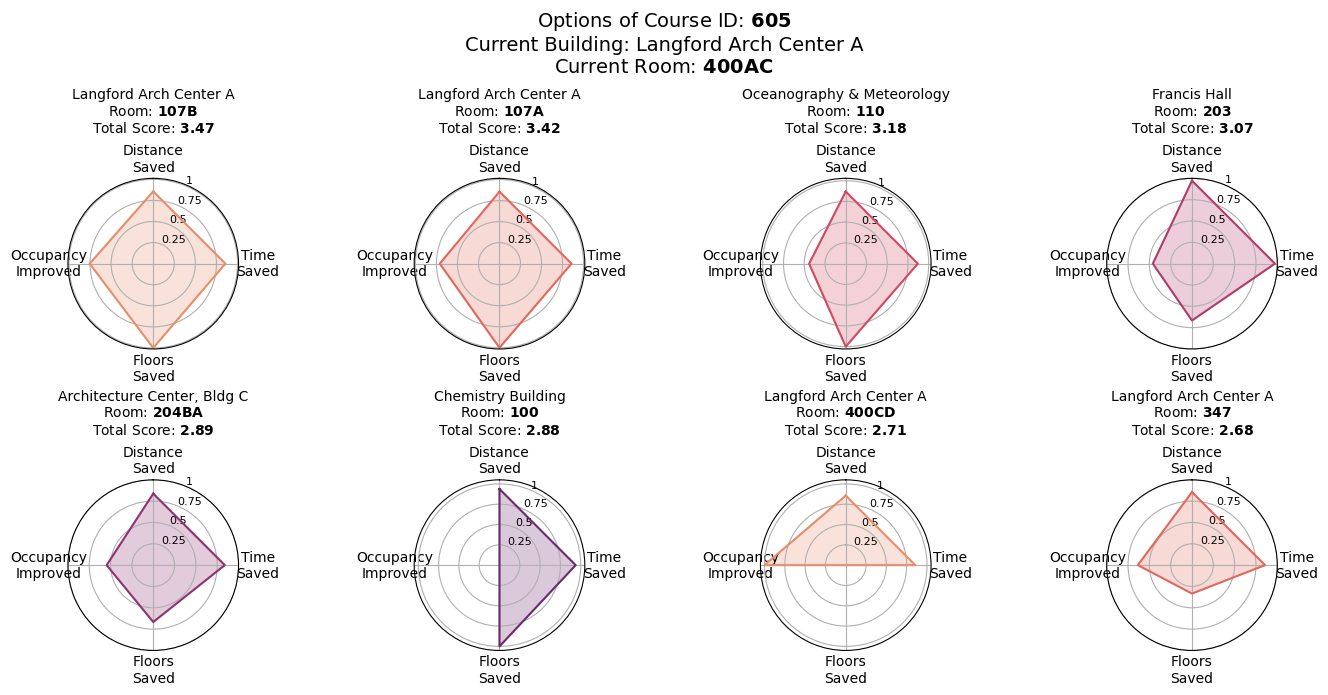

<Figure size 640x480 with 0 Axes>

{'id': 2, 'current_course': {'course_number': 658, 'room': '323', 'building': 'Langford Arch Center A', 'building_id': 398, 'building_location': (30.618803876316907, -96.33763910653171), 'start_time': '11:30', 'end_time': '12:45', 'floor': 3, 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 6, 'room_capacity': 25, 'num_students': 21, 'occupancy_rate': 0.84}, 'Options': [{'course_number': 658, 'room': '300A', 'building': 'Langford Arch Center A', 'building_id': '398', 'building_location': (30.618803876316907, -96.33763910653171), 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 5, 'room_capacity': 25, 'num_students': 21, 'distance_saved': 0.0, 'time_saved': 0.0, 'floors_saved': 1, 'occupancy_improved': 0.0, 'distance_saved_normalized': 1.0, 'time_saved_normalized': 1.0, 'floors_saved_normalized': 0.3333333333333333, 'occupancy_improved_normalized': 1.0, 'total_score': 3.3333333333333335}, {'course_number': 658, 'room': '112', 'building': 'Francis Hall', 'building_i

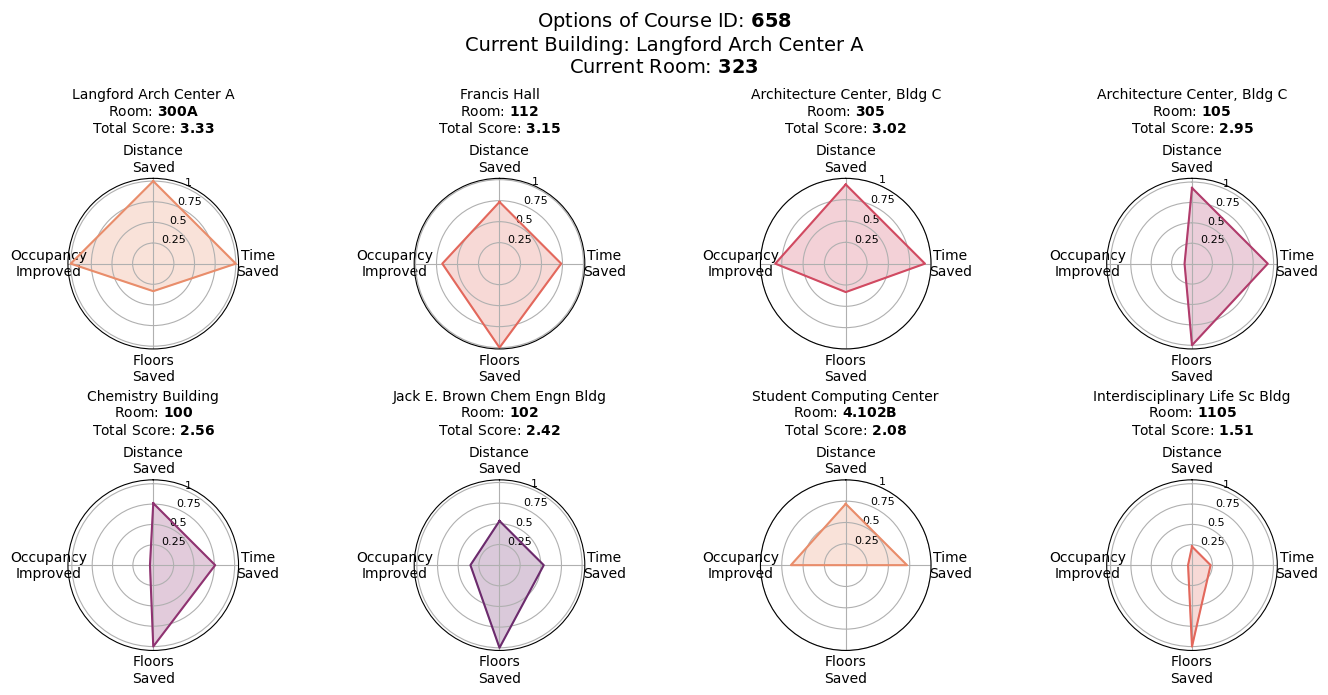

<Figure size 640x480 with 0 Axes>

In [9]:
plot_radar_with_adjustable_subplots(complete_course_chain_updated, subplots_per_row=4)

In [10]:
def dynamic_reschedule_with_propagated_updates(
    course_list,
    updated_courses_info,
    room_timetable,
    building_loc,
    origin_lat_lon,
    origin_building_name,
    time_before_start=20,
    topk=3
):
    """
    Dynamically reschedule courses starting from the origin, updating the alternatives
    for each subsequent course based on the top-1 alternative selected for the previous course.
    """
    import copy

    # Create a copy to dynamically record changes
    updated_courses_info_dynamic = copy.deepcopy(updated_courses_info)

    def update_course_info_dynamic(course_id, new_building, new_room, new_location, updated_courses_info_dynamic, building_loc):
        """
        Update the course information dynamically in updated_courses_info_dynamic.
        Ensure all necessary elements are updated, including building details, room details, and capacities.
        """
        building_number = None

        # Find the building number matching the new location
        for key, value in building_loc.items():
            if value["lat"] == new_location["lat"] and value["lon"] == new_location["lon"]:
                building_number = key
                break

        if building_number is None:
            raise ValueError(f"Building location {new_location} not found in building_loc")

        # Update the course information
        for course in updated_courses_info_dynamic['courses']:
            if course['CourseNumb'] == course_id:
                course['RoomNumber'] = new_room
                course['BuildingName'] = new_building
                course['BuildingNumber'] = building_number

                # Update related building attributes from `building_loc`
                building_data = building_loc[building_number]
                course['BldgAbbr'] = building_data.get("abbr", "N/A")  # Update building abbreviation
                course['Region'] = building_data.get("region", "N/A")  # Update region if available

                # Ensure capacity remains consistent
                course['RoomCapacity'] = building_data.get("room_capacity", course.get('RoomCapacity', "N/A"))

                # No change to other static attributes like `NumStudents`
                break

    course_chain = {}

    # Add origin to the chain
    origin_info = {
        "CourseNumb": "Origin",
        "room": "N/A",
        "building": origin_building_name,
        "building_location": origin_lat_lon,
        "start_time": "N/A",
        "end_time": "N/A",
        "floor": "N/A",
        "room_capacity": "N/A",
        "num_students": "N/A",
        "occupancy_rate": "N/A"
    }

    # Fetch options for the first course (C1) from Origin
    first_course_id = course_list[0]
    origin_result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
        "Origin", first_course_id, updated_courses_info_dynamic, room_timetable, building_loc, topk, origin_location=origin_lat_lon
    )
    origin_options = origin_result["alternatives"]

    # Select the top-1 option for the first course (C1)
    top_option_c1 = origin_options[0] if origin_options else None

    # Add Origin information to the chain
    course_chain["Origin"] = {
        "id": 0,
        "original_current_course": origin_info,
        "original_next_course": next(course for course in updated_courses_info["courses"] if course["CourseNumb"] == first_course_id),
        "original_options_for_next_course": [
            {
                **opt,
                "metrics": {
                    "distance_saved": opt["distance_saved"],
                    "time_saved": opt["time_saved"],
                    "floors_saved": opt["floors_saved"],
                    "occupancy_improved": opt["occupancy_improved"],
                    "normalized": {
                        "distance_saved_normalized": opt["distance_saved_normalized"],
                        "time_saved_normalized": opt["time_saved_normalized"],
                        "floors_saved_normalized": opt["floors_saved_normalized"],
                        "occupancy_improved_normalized": opt["occupancy_improved_normalized"]
                    }
                },
                "total_score": opt["total_score"]
            } for opt in origin_options
        ],
        "updated_current_course": origin_info,
        "updated_options_for_next_course": [
            {
                **opt,
                "metrics": {
                    "distance_saved": opt["distance_saved"],
                    "time_saved": opt["time_saved"],
                    "floors_saved": opt["floors_saved"],
                    "occupancy_improved": opt["occupancy_improved"],
                    "normalized": {
                        "distance_saved_normalized": opt["distance_saved_normalized"],
                        "time_saved_normalized": opt["time_saved_normalized"],
                        "floors_saved_normalized": opt["floors_saved_normalized"],
                        "occupancy_improved_normalized": opt["occupancy_improved_normalized"]
                    }
                },
                "total_score": opt["total_score"]
            } for opt in origin_options
        ],
        "updated_next_course": top_option_c1
    }

    # Update C1 in updated_courses_info_dynamic based on the selected option
    if top_option_c1:
        update_course_info_dynamic(
            first_course_id,
            top_option_c1["building"],
            top_option_c1["room"],
            {"lat": top_option_c1["building_location"][0], "lon": top_option_c1["building_location"][1]},
            updated_courses_info_dynamic,
            building_loc
        )

    # Iterate over the rest of the course list
    for idx in range(len(course_list)):
        current_course_id = course_list[idx]
        if idx < len(course_list) - 1:
            next_course_id = course_list[idx + 1]

            # Fetch original options for the next course (C_{i+1}) based on updated current course (C_i)
            original_result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
                current_course_id, next_course_id, updated_courses_info, room_timetable, building_loc, topk
            )
            original_options = original_result["alternatives"]

            # Fetch updated options for the next course (C_{i+1}) based on updated current course (C_i)
            updated_result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
                current_course_id, next_course_id, updated_courses_info_dynamic, room_timetable, building_loc, topk
            )
            updated_options = updated_result["alternatives"]

            # Select the top-1 option for the next course (C_{i+1})
            top_option_next = updated_options[0] if updated_options else None

            # Update the next course (C_{i+1}) in updated_courses_info_dynamic dynamically
            if top_option_next:
                update_course_info_dynamic(
                    next_course_id,
                    top_option_next["building"],
                    top_option_next["room"],
                    {"lat": top_option_next["building_location"][0], "lon": top_option_next["building_location"][1]},
                    updated_courses_info_dynamic,
                    building_loc
                )

            # Add information for the current course to the chain
            course_chain[f"Course_{idx + 1}"] = {
                "id": idx + 1,
                "original_current_course": next(course for course in updated_courses_info["courses"] if course["CourseNumb"] == current_course_id),
                "original_next_course": next(course for course in updated_courses_info["courses"] if course["CourseNumb"] == next_course_id),
                "original_options_for_next_course": [
                    {
                        **opt,
                        "metrics": {
                            "distance_saved": opt["distance_saved"],
                            "time_saved": opt["time_saved"],
                            "floors_saved": opt["floors_saved"],
                            "occupancy_improved": opt["occupancy_improved"],
                            "normalized": {
                                "distance_saved_normalized": opt["distance_saved_normalized"],
                                "time_saved_normalized": opt["time_saved_normalized"],
                                "floors_saved_normalized": opt["floors_saved_normalized"],
                                "occupancy_improved_normalized": opt["occupancy_improved_normalized"]
                            }
                        },
                        "total_score": opt["total_score"]
                    } for opt in original_options
                ],
                "updated_current_course": next(course for course in updated_courses_info_dynamic["courses"] if course["CourseNumb"] == current_course_id),
                "updated_options_for_next_course": [
                    {
                        **opt,
                        "metrics": {
                            "distance_saved": opt["distance_saved"],
                            "time_saved": opt["time_saved"],
                            "floors_saved": opt["floors_saved"],
                            "occupancy_improved": opt["occupancy_improved"],
                            "normalized": {
                                "distance_saved_normalized": opt["distance_saved_normalized"],
                                "time_saved_normalized": opt["time_saved_normalized"],
                                "floors_saved_normalized": opt["floors_saved_normalized"],
                                "occupancy_improved_normalized": opt["occupancy_improved_normalized"]
                            }
                        },
                        "total_score": opt["total_score"]
                    } for opt in updated_options
                ],
                "updated_next_course": top_option_next
            }
        else:
            # For the last course, add its information without "next course" details
            last_result = find_alternative_classrooms_with_combined_metric_updated_for_origin(
                current_course_id, current_course_id, updated_courses_info_dynamic, room_timetable, building_loc, topk
            )
            last_options = last_result["alternatives"]

            course_chain[f"Course_{idx + 1}"] = {
                "id": idx + 1,
                "original_current_course": next(course for course in updated_courses_info["courses"] if course["CourseNumb"] == current_course_id),
                "original_options_for_current_course": [
                    {
                        **opt,
                        "metrics": {
                            "distance_saved": opt["distance_saved"],
                            "time_saved": opt["time_saved"],
                            "floors_saved": opt["floors_saved"],
                            "occupancy_improved": opt["occupancy_improved"],
                            "normalized": {
                                "distance_saved_normalized": opt["distance_saved_normalized"],
                                "time_saved_normalized": opt["time_saved_normalized"],
                                "floors_saved_normalized": opt["floors_saved_normalized"],
                                "occupancy_improved_normalized": opt["occupancy_improved_normalized"]
                            }
                        },
                        "total_score": opt["total_score"]
                    } for opt in last_options
                ],
                "updated_current_course": next(course for course in updated_courses_info_dynamic["courses"] if course["CourseNumb"] == current_course_id)
            }

    return course_chain, updated_courses_info_dynamic

# Usage example
course_list = [325, 661, 463, 612, 321]
origin_lat_lon = {"lat": 30.61507082693666, "lon": -96.34047976538754}
origin_building_name = "Nagle Hall"

dynamic_course_chain_propagated, final_updated_courses_info = dynamic_reschedule_with_propagated_updates(
    course_list,
    updated_courses_info,
    room_timetable,
    building_loc,
    origin_lat_lon,
    origin_building_name,
    time_before_start=20,
    topk=10
)

print(json.dumps(dynamic_course_chain_propagated, indent=4))

{
    "Origin": {
        "id": 0,
        "original_current_course": {
            "CourseNumb": "Origin",
            "room": "N/A",
            "building": "Nagle Hall",
            "building_location": {
                "lat": 30.61507082693666,
                "lon": -96.34047976538754
            },
            "start_time": "N/A",
            "end_time": "N/A",
            "floor": "N/A",
            "room_capacity": "N/A",
            "num_students": "N/A",
            "occupancy_rate": "N/A"
        },
        "original_next_course": {
            "CourseNumb": 325,
            "SectionNumb": 500,
            "SectionID": 46428,
            "MeetingType": "LEC",
            "MeetingID": 959440,
            "DayOfWeek": "Mon",
            "RoomNumber": "100",
            "BuildingName": "Chemistry Building",
            "BuildingNumber": 484.0,
            "BldgAbbr": "CHEM",
            "Region": "East Campus",
            "NumStudents": 260,
            "StartTimeStr": "10:20

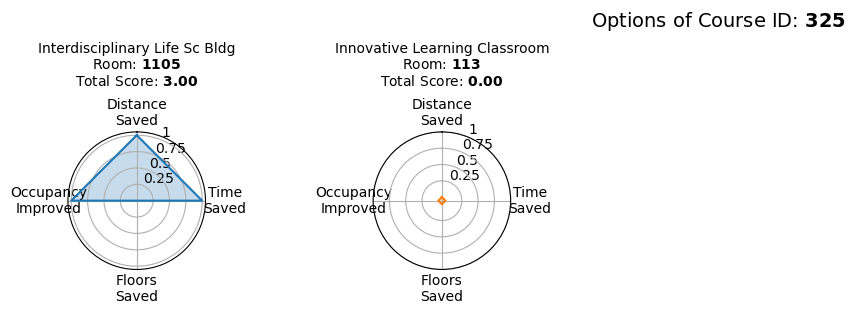

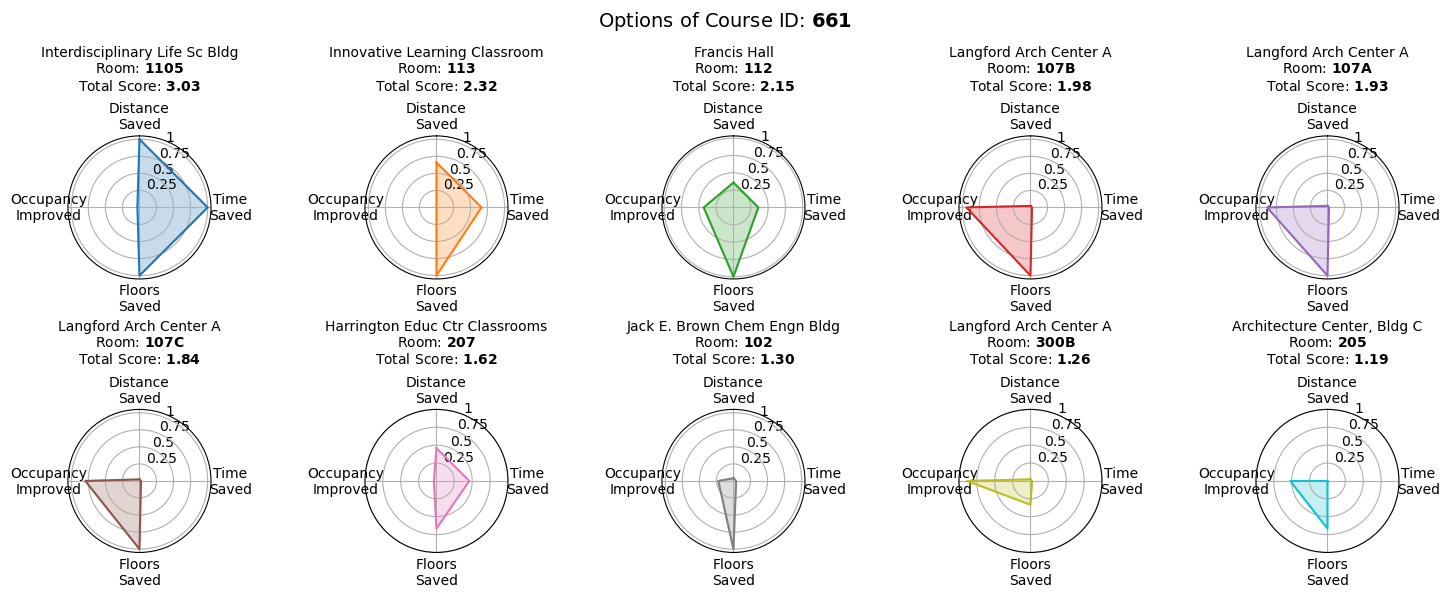

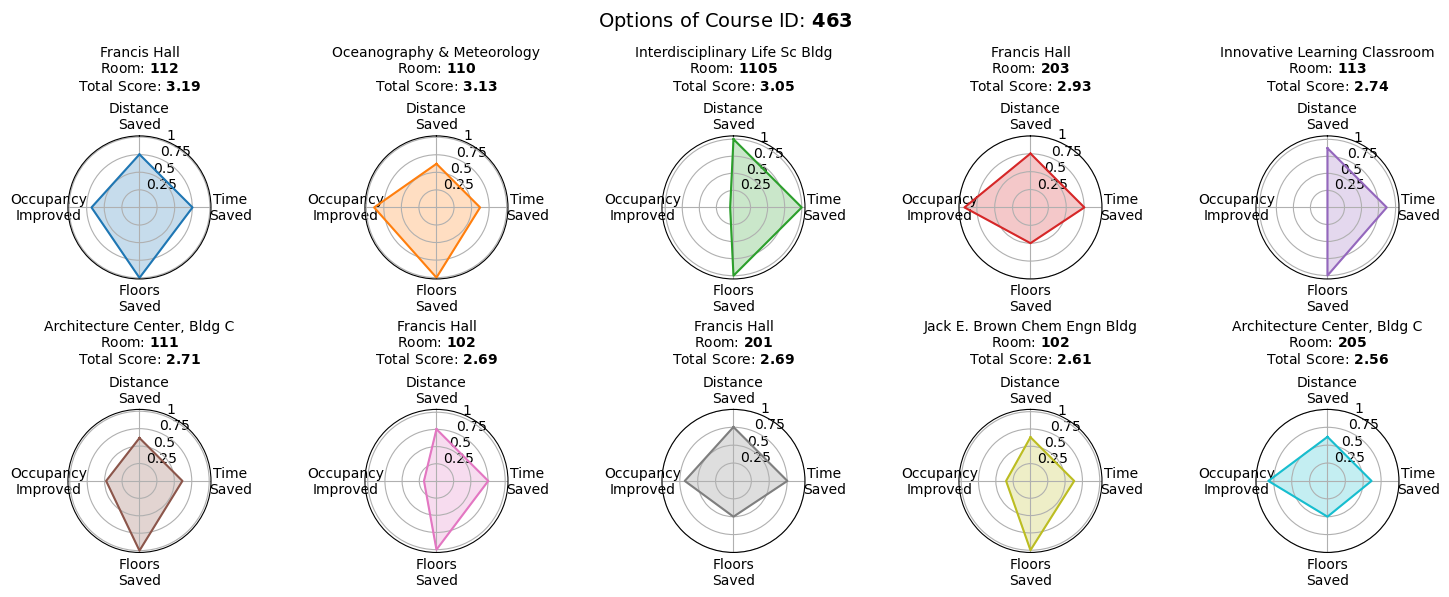

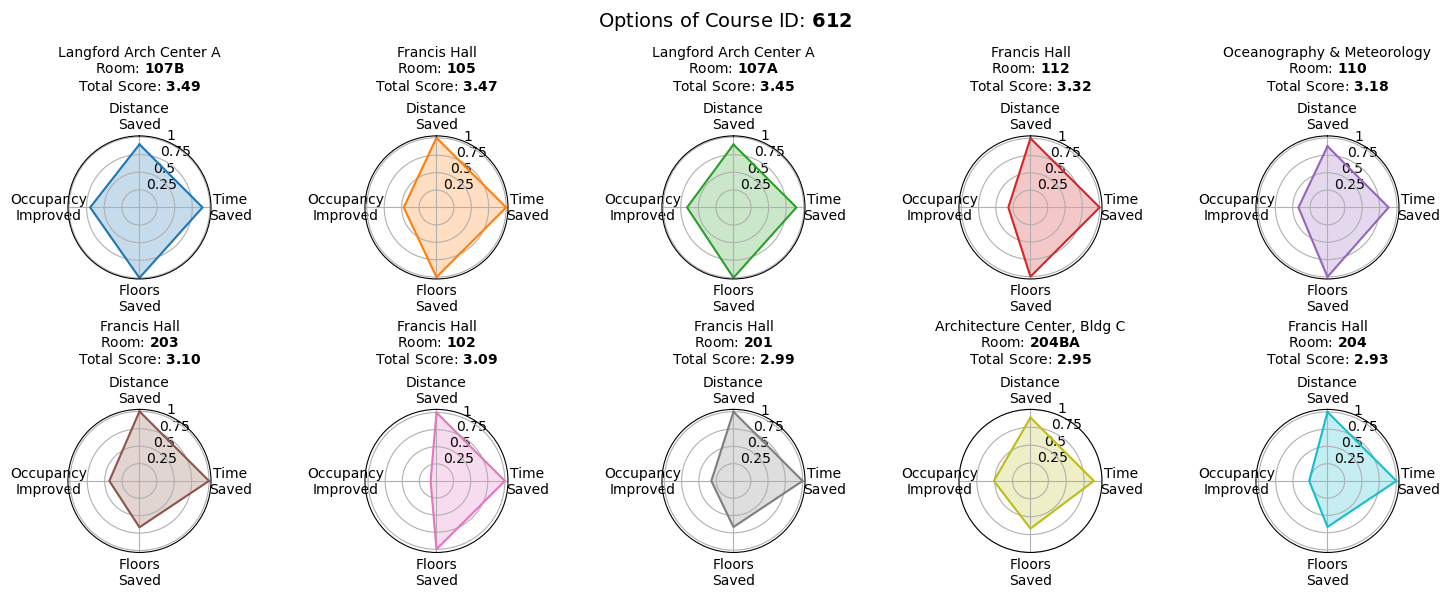

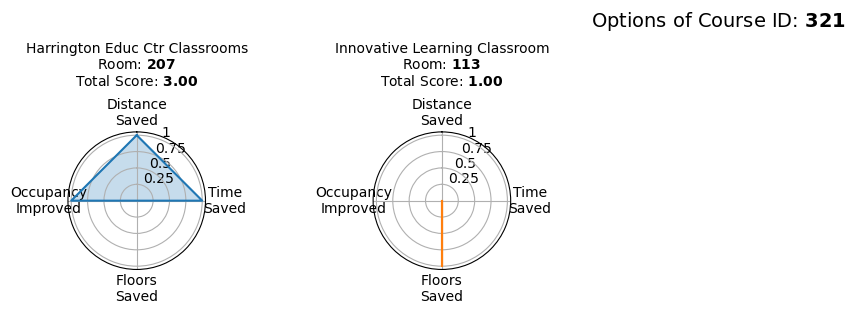

{'id': 5, 'original_current_course': {'CourseNumb': 321, 'SectionNumb': 502, 'SectionID': 54285, 'MeetingType': 'LEC', 'MeetingID': 982379, 'DayOfWeek': 'Mon', 'RoomNumber': '1105', 'BuildingName': 'Interdisciplinary Life Sc Bldg', 'BuildingNumber': 1530.0, 'BldgAbbr': 'ILSB', 'Region': 'East Campus', 'NumStudents': 252, 'StartTimeStr': '16:10', 'EndTimeStr': '17:25', 'RoomCapacity': 285}, 'original_options_for_current_course': [{'course_number': 321, 'room': '207', 'building': 'Harrington Educ Ctr Classrooms', 'building_id': '438', 'building_location': (30.61688442919367, -96.34042969920843), 'travel_distance': 0.0, 'travel_time': 0.0, 'total_floors': 2, 'room_capacity': 256, 'num_students': 252, 'distance_saved': 0.0, 'time_saved': 0.0, 'floors_saved': 1, 'occupancy_improved': 0.10016447368421055, 'distance_saved_normalized': 1.0, 'time_saved_normalized': 1.0, 'floors_saved_normalized': 0.0, 'occupancy_improved_normalized': 1.0, 'total_score': 3.0, 'metrics': {'distance_saved': 0.0, 

In [11]:
def plot_radar_with_adjustable_subplots(course_chain, subplots_per_row=3):
    """
    Plot radar charts for the four metrics (distance_saved, time_saved, floors_saved, occupancy_improved)
    for all the options of each course in the course chain, with adjustable subplots per row and enhanced visuals.
    """

    # Metrics and their normalized counterparts
    metrics = ["distance_saved", "time_saved", "floors_saved", "occupancy_improved"]
    normalized_metrics = [f"{metric}_normalized" for metric in metrics]
    num_metrics = len(normalized_metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart loop

    # Define nicer labels for the metrics
    metric_labels = {
        "distance_saved_normalized": "Distance\nSaved",
        "time_saved_normalized": "Time\nSaved",
        "floors_saved_normalized": "Floors\nSaved",
        "occupancy_improved_normalized": "Occupancy\nImproved"
    }

    # Define colors for better visual effect
    color_palette = list(mcolors.TABLEAU_COLORS.values())

    # Loop through each course in the chain, sorted by ID for consistency
    for course_key in sorted(course_chain.keys(), key=lambda k: course_chain[k]["id"]):
        course_data = course_chain[course_key]
        # print(course_data)
        # Ensure there are options available for radar plotting
        if "updated_options_for_next_course" not in course_data or not course_data["updated_options_for_next_course"]:
            print(print(course_data))
            continue

        options = course_data["updated_options_for_next_course"]
        num_options = len(options)
        rows = (num_options + subplots_per_row - 1) // subplots_per_row
        fig, axs = plt.subplots(rows, subplots_per_row, figsize=(subplots_per_row * 3, rows * 3), subplot_kw=dict(polar=True))
        axs = axs.flatten() if num_options > 1 else [axs]

        # Retrieve the course ID for the title
        current_course_id = course_data["updated_next_course"]["course_number"]

        for i, option in enumerate(options):
            values = [option["metrics"]["normalized"].get(metric, 0) for metric in normalized_metrics]
            values += values[:1]  # Close the radar chart loop
            ax = axs[i]
            ax.set_theta_offset(np.pi / 2)
            ax.set_theta_direction(-1)

            # Plot the radar chart for this option
            ax.plot(angles, values, label=f"Room: {option['room']}", color=color_palette[i % len(color_palette)])
            ax.fill(angles, values, alpha=0.25, color=color_palette[i % len(color_palette)])

            # Add gridlines and labels
            ax.set_yticks([0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(["0.25", "0.5", "0.75", "1"], fontsize=10)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels([metric_labels[m] for m in normalized_metrics], fontsize=10)
            total_score = option.get("total_score", 0)
            ax.set_title(
                f"{option['building']}\nRoom: $\mathbf{{{option['room']}}}$\nTotal Score: $\mathbf{{{total_score:.2f}}}$",
                va="bottom",
                fontsize=10
            )

        # Add empty subplots if necessary
        for j in range(num_options, len(axs)):
            fig.delaxes(axs[j])  # Mark unused axes as empty


        # Correctly set suptitle from the first course to the last
        suptitle = f"Options of Course ID: $\mathbf{{{current_course_id}}}$"
        fig.suptitle(suptitle, fontsize=14)
        plt.tight_layout()
        plt.show()

# Example usage with adjustable subplots per row
plot_radar_with_adjustable_subplots(dynamic_course_chain_propagated, subplots_per_row=5)